# 主題模型 - LDA

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import ast

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
from matplotlib import font_manager
font_set = {f.name for f in font_manager.fontManager.ttflist}
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False

### 資料載入

In [4]:
df = pd.read_csv("../data/sentiment/nissan_clean_data.csv")
df

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,words,sentimentRatio
0,1,https://www.ptt.cc/bbs/car/M.1606752584.A.175....,[新聞]小休旅熱鬧好玩PEUGEOT30081.5LBlueH,2020-12-01,car,原文連結：https://ctee.com.tw/lohas/car/378518.html...,"['小休', '熱鬧', '好玩', 'PEUGEOT30081', '5LBlueH']",1.0
1,2,https://www.ptt.cc/bbs/car/M.1606794935.A.AA7....,[情報]2020年11月份臺灣汽車市場銷售報告,2020-12-01,car,新增小七車https://www.7car.tw/articles/read/70876?馬...,"['月份', '臺灣汽車', '市場', '銷售', '報告', '新增', '小七車']",0.5
2,3,https://www.ptt.cc/bbs/car/M.1606809497.A.DB9....,[新聞]豐田Premio/Allion/PriusAlpha明年停產,2020-12-01,car,標題：房車與轎式MPV式微影響，Toyota Premio/Allion/Prius α 將...,"['豐田', 'Premio', 'Allion', 'PriusAlpha', '明年',...",0.5
3,4,https://www.ptt.cc/bbs/car/M.1606815989.A.3D7....,[討論]缺點才是選車重點,2020-12-01,car,最近new juke的試駕影片慢慢釋出了8891的影片結尾依舊提出了3好3壞https://...,"['缺點', '選車', '重點', 'new', 'juke', '試駕', '影片', ...",0.0
4,5,https://www.ptt.cc/bbs/car/M.1606821239.A.6CC....,[菜單]NissanAllNEWSentra尊爵型,2020-12-01,car,車輛廠牌/年份/型號：Nissan/2020/All New Sentra車輛原廠編成等級：...,"['NissanAllNEWSentra', '尊爵型', 'Nissan', 'All',...",1.0
...,...,...,...,...,...,...,...,...
2074,2459,https://www.ptt.cc/bbs/CarShop/M.1674310865.A....,[購車],2023-01-21,CarShop,s車輛狀況：二手休旅車車輛品牌： Honda、Toyota、Lexus、Nissan車款型式...,"['休旅車', 'Honda', 'Toyota', 'Lexus', 'Nissan', ...",0.5
2075,2461,https://www.ptt.cc/bbs/CarShop/M.1674546686.A....,[售車]Nissan2013BIGTIIDA5門,2023-01-24,CarShop,車輛品牌/產地/出廠年月：NISSAN 2013/1月車款型式/排氣量：BIG TIIDA ...,"['Nissan2013BIGTIIDA5', 'NISSAN', '2013', 'BIG...",0.5
2076,2462,https://www.ptt.cc/bbs/CarShop/M.1674724913.A....,[售車]Nissankicks智行旗艦版（2019）,2023-01-26,CarShop,車輛品牌/產地/出廠年月： 2019年06月車款型式/排氣量：1498顏色/排檔形式：白色橘...,"['Nissankicks', '智行', '旗艦版', '2019', '2019', '...",0.0
2077,2463,https://www.ptt.cc/bbs/CarShop/M.1674726151.A....,[售車]自售NISSANTEANAJ3120052.0,2023-01-26,CarShop,車輛品牌/產地/出廠年月： 2005年06月車款型式/排氣量：J31 TEANA 2.0顏色...,"['自售', 'NISSANTEANAJ3120052', '2005', '06', 'J...",0.5


In [57]:
# 格式處理
df['words'] = df['words'].apply(lambda x: ast.literal_eval(x))
df['words'] = df['words'].apply(lambda x: ' '.join(x))

In [58]:
docs = df['words']
docs[0]

'小休 熱鬧 好玩 PEUGEOT30081 5LBlueH'

In [59]:
docs_tokenized = [doc.split() for doc in docs]  # 將每個字符串分詞成單詞的列表

dictionary = Dictionary(docs_tokenized)
dictionary.filter_extremes(no_below=100, no_above=0.85)
print(dictionary)

2023-06-13 01:27:51,786 : INFO : adding document #0 to Dictionary<0 unique tokens: []>


2023-06-13 01:27:52,114 : INFO : built Dictionary<40273 unique tokens: ['5LBlueH', 'PEUGEOT30081', '好玩', '小休', '熱鬧']...> from 2079 documents (total 253029 corpus positions)
2023-06-13 01:27:52,115 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<40273 unique tokens: ['5LBlueH', 'PEUGEOT30081', '好玩', '小休', '熱鬧']...> from 2079 documents (total 253029 corpus positions)", 'datetime': '2023-06-13T01:27:52.115451', 'gensim': '4.3.1', 'python': '3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}
2023-06-13 01:27:52,155 : INFO : discarding 40079 tokens: [('5LBlueH', 1), ('PEUGEOT30081', 1), ('好玩', 5), ('小休', 24), ('熱鬧', 5), ('報告', 46), ('小七車', 1), ('新增', 8), ('月份', 35), ('臺灣汽車', 13)]...
2023-06-13 01:27:52,156 : INFO : keeping 194 tokens which were in no less than 100 and no more than 1767 (=85.0%) documents
2023-06-13 01:27:52,168 : INFO : resulting dictionary: Dictionary<194 unique token

Dictionary<194 unique tokens: ['市場', 'Toyota', '房車', '豐田', '缺點']...>


In [60]:
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs_tokenized]

corpus[0][:3]

[]

### 模型建立

**透過指標找出最佳主題數**

In [61]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=10, # 訓練次數
        alpha = 0.08,
        eta = 0.1,
        iterations=1000,
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2023-06-13 01:27:52,306 : INFO : using serial LDA version on this node
2023-06-13 01:27:52,308 : INFO : running online (multi-pass) LDA training, 2 topics, 10 passes over the supplied corpus of 2079 documents, updating model once every 2000 documents, evaluating perplexity every 2079 documents, iterating 1000x with a convergence threshold of 0.001000
2023-06-13 01:27:52,308 : INFO : PROGRESS: pass 0, at document #2000/2079
2023-06-13 01:27:53,614 : INFO : merging changes from 2000 documents into a model of 2079 documents
2023-06-13 01:27:53,616 : INFO : topic #0 (0.080): 0.021*"空間" + 0.020*"價格" + 0.019*"Nissan" + 0.018*"考慮" + 0.017*"問題" + 0.015*"原廠" + 0.015*"日本" + 0.014*"新車" + 0.014*"中國" + 0.013*"安全"
2023-06-13 01:27:53,616 : INFO : topic #1 (0.080): 0.023*"問題" + 0.020*"仙草" + 0.019*"業務" + 0.018*"裕隆" + 0.017*"空間" + 0.014*"喜歡" + 0.013*"Nissan" + 0.013*"保養" + 0.013*"不錯" + 0.013*"原廠"
2023-06-13 01:27:53,617 : INFO : topic diff=0.499316, rho=1.000000
2023-06-13 01:27:53,652 : INFO : -5.342 

花費時間: 90.48587560653687 sec


In [62]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,161.729722,inf
1,3,137.292180,inf
2,4,132.099077,inf
3,5,124.180816,inf
4,6,129.901626,inf
5,7,119.761979,inf
6,8,120.800844,inf
7,9,122.340437,inf


<Axes: xlabel='topic_num'>

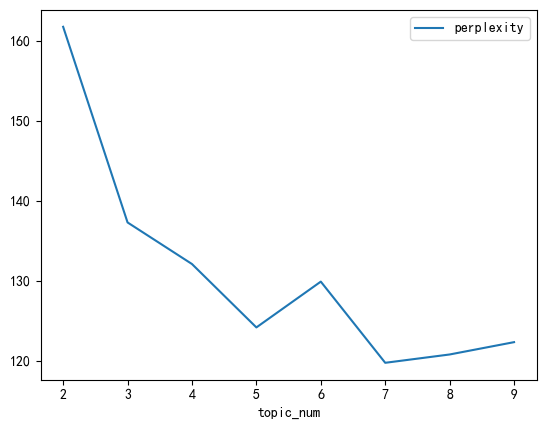

In [63]:
result.plot.line(x='topic_num', y='perplexity')

In [64]:
# result.plot.line(x='topic_num', y='pmi')

### 視覺化最佳模型

In [65]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 1500,
    passes=10, # 訓練次數
    alpha = 0.08,
    eta = 0.1,
    iterations=1000,
    )

2023-06-13 01:29:23,073 : INFO : using serial LDA version on this node
2023-06-13 01:29:23,074 : INFO : running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 2079 documents, updating model once every 2000 documents, evaluating perplexity every 2079 documents, iterating 1000x with a convergence threshold of 0.001000
2023-06-13 01:29:23,074 : INFO : PROGRESS: pass 0, at document #2000/2079
2023-06-13 01:29:24,849 : INFO : merging changes from 2000 documents into a model of 2079 documents
2023-06-13 01:29:24,850 : INFO : topic #0 (0.080): 0.027*"日產" + 0.025*"原廠" + 0.024*"空間" + 0.021*"價格" + 0.021*"日本" + 0.020*"新車" + 0.016*"里程" + 0.015*"豐田" + 0.015*"需求" + 0.015*"Nissan"
2023-06-13 01:29:24,851 : INFO : topic #1 (0.080): 0.039*"仙草" + 0.025*"問題" + 0.020*"福特" + 0.020*"空間" + 0.017*"馬自達" + 0.017*"保養" + 0.017*"變速箱" + 0.015*"原廠" + 0.013*"便宜" + 0.012*"Sentra"
2023-06-13 01:29:24,851 : INFO : topic #2 (0.080): 0.025*"問題" + 0.024*"中國" + 0.020*"裕隆" + 0.017*"Nissan" 

In [66]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.164202 -0.086040       1        1  34.365145
2     -0.219324  0.031716       2        1  28.917278
1     -0.189369  0.057023       3        1  21.195956
0      0.277507 -0.247388       4        1   9.158088
4      0.295388  0.244690       5        1   6.363533, topic_info=       Term        Freq       Total Category  logprob  loglift
7    Nissan  914.000000  914.000000  Default  30.0000  30.0000
65       顏色  380.000000  380.000000  Default  29.0000  29.0000
147      排檔  375.000000  375.000000  Default  28.0000  28.0000
190      形式  373.000000  373.000000  Default  27.0000  27.0000
138      仙草  700.000000  700.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
170      年式   13.208013  128.279144   Topic5  -5.5950   0.4812
148      旗艦   37.511161  367.038790   Topic5  -4.5512   0.4738
12       保養   63.452968  624.888613   Topic5  -4.0255   0.4673
14       原廠   54.817423  791.439289   Topic5  -4.1718   0.0847
154     二手車   22.551917  254.491225   Topic5  -5.0600   0.3311

[217 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
89        1  0.301301   100
89        2  0.612646   100
89        3  0.080347   100
112       1  0.680100    70
112       2  0.271230    70
...     ...       ...   ...
150       3  0.488063  高速公路
178       1  0.066039    高雄
178       2  0.013208    高雄
178       4  0.574536    高雄
178       5  0.350005    高雄

[478 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1, 5])

儲存結果

In [67]:
pyLDAvis.save_html(p, "../html_files/nissan_lda.html")